In [1]:
import torch,torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import pandas as pd
import wandb
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
PROJECT_NAME = 'Car-Object-Detection-V8-Learning-Detectron2-V2'

In [2]:
data = pd.read_csv('./data.csv').sample(frac=1).sample(frac=1)

In [3]:
data

,image,xmin,ymin,xmax,ymax
519,vid_4_9460.jpg,0.000000,189.461626,59.574654,225.394268
48,vid_4_12240.jpg,587.464544,172.363256,676.000000,220.780245
339,vid_4_26460.jpg,197.125904,192.903797,319.901592,233.984878
130,vid_4_16400.jpg,243.594790,189.969434,271.476122,210.509974
36,vid_4_12120.jpg,334.086831,178.231982,428.492040,223.714607
...,...,...,...,...,...
140,vid_4_17100.jpg,499.418234,185.078829,609.476122,232.517696
82,vid_4_13720.jpg,189.299566,183.611647,228.431259,208.553732
429,vid_4_6240.jpg,393.273517,188.013192,510.668596,233.281853
419,vid_4_6200.jpg,241.149059,181.655405,361.968162,227.627091


In [4]:
img = cv2.imread('./data/vid_4_9980.jpg')

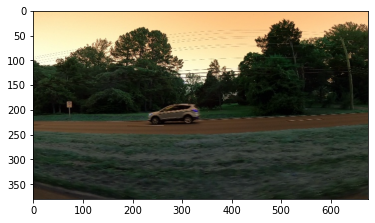

In [5]:
plt.imshow(img)

In [6]:
xmin,ymin,xmax,ymax = 221,182,348,238

In [7]:
x = xmin
y = ymin
w = xmax - xmin
h = ymax - ymin

In [8]:
crop = img[y:y+h,x:x+w]

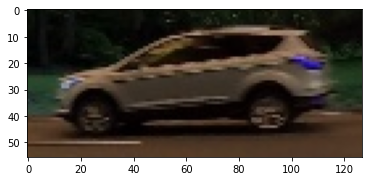

In [9]:
plt.imshow(crop)

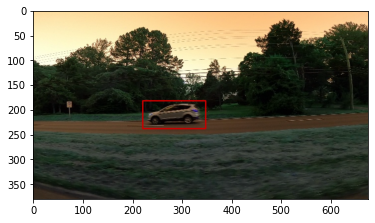

In [10]:
plt.imshow(cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

In [11]:
cv2.imwrite('crop.png',crop)

True

In [12]:
cv2.imwrite('box.png',img)

True

In [13]:
def load_data():
    records = []
    for idx in tqdm(range(len(data))):
        record = {}
        info = data.iloc[idx]
        path = f'./data/{info["image"]}'
        record['file_name'] = path
        record['height'],record['width'] = cv2.imread(path).shape[:2]
        record['image_id'] = idx
        record['annotations'] = [
            {
                'bbox':[info['xmin'],info['ymin'],info['xmax'],info['ymax']],
                'bbox_mode':BoxMode.XYXY_ABS,
                'category_id':0
            }
        ]
        records.append(record)
    return records

In [14]:
labels = ['car']

In [15]:
DatasetCatalog.register('data',lambda : load_data())
MetadataCatalog.get('data').set(thing_classes=labels)
metadata = MetadataCatalog.get('data')

In [16]:
model = "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"

In [23]:
wandb.init(project=PROJECT_NAME,name='baseline')
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.DATASETS.TRAIN = ('data')
cfg.DATASETS.TEST = ()
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
cfg.MODEL.WEIGHTS = './output/model_final.pth'
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator('data',output_dir='./output/')
val_loader = build_detection_test_loader(cfg,'data')
metrics = inference_on_dataset(predictor.model,val_loader,evaluator)
wandb.log(metrics)
img = cv2.imread('./data/vid_4_11420.jpg')
preds = predictor(img)
v = Visualizer(img[:,:,::-1],metadata)
v = v.draw_instance_predictions(preds['instances'].to('cpu'))
v = v.get_image()[:,:,::-1]
plt.figure(figsize=(12,6))
plt.imshow(v)
plt.savefig('./img.png')
plt.close()
wandb.log({'Img':wandb.Image(cv2.imread('./img.png'))})

wandb: Waiting for W&B process to finish, PID 87199
wandb: Program ended successfully.


wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20211018_090022-28y1uij2/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20211018_090022-28y1uij2/logs/debug-internal.log
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: 
wandb: Synced baseline: https://app.wandb.ai/ranuga-d/Car-Object-Detection-V8-Learning-Detectron2-V2/runs/28y1uij2
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.0
wandb: Run data is saved locally in wandb/run-20211018_090625-106y76r3
wandb: Syncing run baseline



[10/18 09:06:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)


100%|████████████████████████████████████████| 559/559 [00:01<00:00, 346.84it/s]

[10/18 09:06:32 d2.data.build]: Removed 0 images with no usable annotations. 559 images left.


[10/18 09:06:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/18 09:06:32 d2.data.build]: Using training sampler TrainingSampler
[10/18 09:06:32 d2.data.common]: Serializing 559 elements to byte tensors and concatenating them all ...
[10/18 09:06:32 d2.data.common]: Serialized dataset takes 0.19 MiB


2021-10-18 09:06:33.483892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model p

[10/18 09:06:37 d2.engine.train_loop]: Starting training from iteration 0
[10/18 09:06:45 d2.utils.events]:  eta: 0:15:56  iter: 19  total_loss: 1.08  loss_cls: 0.6337  loss_box_reg: 0.4406  loss_rpn_cls: 0.00828  loss_rpn_loc: 0.006149  time: 0.3841  data_time: 0.0146  lr: 4.9953e-06  max_mem: 2284M
[10/18 09:06:53 d2.utils.events]:  eta: 0:15:58  iter: 39  total_loss: 1.026  loss_cls: 0.5496  loss_box_reg: 0.457  loss_rpn_cls: 0.008634  loss_rpn_loc: 0.005052  time: 0.3933  data_time: 0.0027  lr: 9.9902e-06  max_mem: 2284M
[10/18 09:07:01 d2.utils.events]:  eta: 0:15:52  iter: 59  total_loss: 0.8309  loss_cls: 0.4379  loss_box_reg: 0.3914  loss_rpn_cls: 0.007142  loss_rpn_loc: 0.005457  time: 0.3935  data_time: 0.0026  lr: 1.4985e-05  max_mem: 2284M
[10/18 09:07:09 d2.utils.events]:  eta: 0:15:43  iter: 79  total_loss: 0.7378  loss_cls: 0.3448  loss_box_reg: 0.3762  loss_rpn_cls: 0.007678  loss_rpn_loc: 0.005334  time: 0.3910  data_time: 0.0025  lr: 1.998e-05  max_mem: 2284M
[10/18 0

100%|████████████████████████████████████████| 559/559 [00:01<00:00, 351.20it/s]

[10/18 09:22:26 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[10/18 09:22:26 d2.data.datasets.coco]: Conversion finished, #images: 559, #annotations: 559
[10/18 09:22:26 d2.data.datasets.coco]: Caching COCO format annotations at './output/data_coco_format.json' ...


100%|████████████████████████████████████████| 559/559 [00:01<00:00, 347.70it/s]

[10/18 09:22:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/18 09:22:27 d2.data.common]: Serializing 559 elements to byte tensors and concatenating them all ...
[10/18 09:22:27 d2.data.common]: Serialized dataset takes 0.19 MiB


[10/18 09:22:27 d2.evaluation.evaluator]: Start inference on 559 batches
[10/18 09:22:30 d2.evaluation.evaluator]: Inference done 11/559. Dataloading: 0.0008 s/iter. Inference: 0.1960 s/iter. Eval: 0.0001 s/iter. Total: 0.1969 s/iter. ETA=0:01:47
[10/18 09:22:35 d2.evaluation.evaluator]: Inference done 34/559. Dataloading: 0.0009 s/iter. Inference: 0.2173 s/iter. Eval: 0.0001 s/iter. Total: 0.2185 s/iter. ETA=0:01:54
[10/18 09:22:40 d2.evaluation.evaluator]: Inference done 58/559. Dataloading: 0.0010 s/iter. Inference: 0.2165 s/iter. Eval: 0.0001 s/iter. Total: 0.2177 s/iter. ETA=0:01:49
[10/18 09:22:45 d2.evaluation.evaluator]: Inference done 80/559. Dataloading: 0.0012 s/iter. Inference: 0.2192 s/iter. Eval: 0.0001 s/iter. Total: 0.2206 s/iter. ETA=0:01:45
[10/18 09:22:50 d2.evaluation.evaluator]: Inference done 103/559. Dataloading: 0.0011 s/iter. Inference: 0.2193 s/iter. Eval: 0.0001 s/iter. Total: 0.2207 s/iter. ETA=0:01:40
[10/18 09:22:56 d2.evaluation.evaluator]: Inference done

AttributeError: module 'matplotlib.pyplot' has no attribute 'fiugre'

In [24]:
plt.figure(figsize=(12,6))
plt.imshow(v)
plt.savefig('./img.png')
plt.close()
wandb.log({'Img':wandb.Image(cv2.imread('./img.png'))})

In [ ]:
torch.save(cfg,'cfg.pt')
torch.save(cfg,'cfg.pth')
torch.save(predictor,'predictor.pt')
torch.save(predictor,'predictor.pth')
torch.save(evaluator,'evaluator.pt')
torch.save(evaluator,'evaluator.pth')
torch.save(v,'img.pt')
torch.save(v,'img.pth')
torch.save(model,'model.pt')
torch.save(model,'model.pth')
torch.save(labels,'labels.pt')
torch.save(labels,'labels.pth')
torch.save(metrics,'metrics.pt')
torch.save(metrics,'metrics.pth')